In [11]:
%pip install catboost

In [12]:
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostRegressor

import random
import os
import re
import warnings
import tqdm

import wandb

warnings.filterwarnings("ignore")

## Set SEED

In [13]:
SEED = 42


def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


seed_everything(SEED)

## Preprocessing

In [14]:
def age_map(x: int) -> int:
    x = int(x)
    if x < 20:
        return 1
    elif x >= 20 and x < 30:
        return 2
    elif x >= 30 and x < 40:
        return 3
    elif x >= 40 and x < 50:
        return 4
    elif x >= 50 and x < 60:
        return 5
    else:
        return 6


def fillna_location(df):
    # location_city 컬럼의 결측치를 처리 -> 전체 최빈값
    df['location_state'].replace(' ', np.nan, inplace=True)
    mode_city = df["location_city"].mode()[0]
    df["location_city"].fillna(mode_city, inplace=True)

    # location_state 컬럼의 결측치를 처리
    # 먼저, 각 도시별 가장 빈번한 주를 계산
    state_by_city = df.groupby("location_city")["location_state"].apply(
        lambda x: x.mode()[0] if not x.mode().empty else "Unknown"
    )
    # 그리고 이 정보를 사용하여 결측치를 채움
    df["location_state"] = df.apply(
        lambda row: state_by_city[row["location_city"]]
        if pd.isnull(row["location_state"])
        else row["location_state"],
        axis=1,
    )

    # location_country 컬럼의 결측치를 처리
    # 먼저, 각 주별 가장 빈번한 국가를 계산
    country_by_state = df.groupby("location_state")["location_country"].apply(
        lambda x: x.mode()[0] if not x.mode().empty else "Unknown"
    )
    # 그리고 이 정보를 사용하여 결측치를 채움
    df["location_country"] = df.apply(
        lambda row: country_by_state[row["location_state"]]
        if pd.isnull(row["location_country"])
        else row["location_country"],
        axis=1,
    )
    return df


def convert_ISBN10_to_ISBN13(isbn10_series):
    def calculate_check_digit(isbn):
        # ISBN-13의 체크 디지트를 계산하는 함수
        isbn = "978" + isbn[:-1]  # ISBN-13으로 확장하기 위해 앞에 '978' 추가
        check = sum(
            (3 if i % 2 == 0 else 1) * int(digit) for i, digit in enumerate(isbn)
        )  # 체크 디지트 계산
        check_digit = (10 - (check % 10)) % 10  # 10의 배수로 만들기 위해 나머지 계산
        return str(check_digit)

    # ISBN-10을 ISBN-13으로 변환하는 함수

    if len(isbn10_series) != 10 or not isbn10_series[:-1].isdigit():
        return "0000000000"
    else:
        return "978" + isbn10_series[:-1] + calculate_check_digit(isbn10_series)


def get_language_from_isbn13(isbn13):
    """Get the representative language from the ISBN-13 country/region code."""
    # Extracting the country/region code from the ISBN-13
    # ISBN-13 starts with 978 or 979, followed by the country/region code

    country_code = int(isbn13[3:5])  # Using first two digits of the country/region code

    # Mapping of country/region code to representative language
    language_map = {
        0: "en",
        1: "en",  # English
        2: "fr",  # French
        3: "de",  # German
        4: "ja",  # Japanese
        5: "ru",  # Russian
        7: "zh",  # Chinese
        80: "cs",
        81: "hi",
        82: "no",
        83: "pl",
        84: "es",
        85: "pt",
        86: "sr",
        87: "da",
        88: "it",
        89: "ko",
        90: "nl",
        91: "sv"  # Dutch, Swedish
        # ... (other mappings can be added as needed)
    }

    return language_map.get(country_code, "en")


def category_integration(books):
    """
    category를 category_high로 병합
    """
    books.loc[books[books["category"].notnull()].index, "category"] = books[
        books["category"].notnull()
    ]["category"].apply(lambda x: re.sub("[\W_]+", " ", x).strip())
    books["category"] = books["category"].str.lower()

    categories = [
        "garden",
        "crafts",
        "physics",
        "adventure",
        "music",
        "fiction",
        "nonfiction",
        "science",
        "science fiction",
        "social",
        "homicide",
        "sociology",
        "disease",
        "religion",
        "christian",
        "philosophy",
        "psycholog",
        "mathemat",
        "agricult",
        "environmental",
        "business",
        "poetry",
        "drama",
        "literary",
        "travel",
        "motion picture",
        "children",
        "cook",
        "literature",
        "electronic",
        "humor",
        "animal",
        "bird",
        "photograph",
        "computer",
        "house",
        "ecology",
        "family",
        "architect",
        "camp",
        "criminal",
        "language",
        "india",
    ]

    books["category"] = np.where(
        books["category"].isna(), np.random.choice(categories), books["category"]
    )

    books["category_high"] = books["category"].copy()

    for category in categories:
        books.loc[
            books[books["category"].str.contains(category, na=False)].index,
            "category_high",
        ] = category

    category_high_df = pd.DataFrame(books["category_high"].value_counts()).reset_index()
    category_high_df.columns = ["category", "count"]

    others_list = category_high_df[category_high_df["count"] < 5]["category"].values
    books.loc[
        books[books["category_high"].isin(others_list)].index, "category_high"
    ] = "others"

    return books

## Data Load

In [15]:
path = "./data/"
users = pd.read_csv(path + "users.csv")
books = pd.read_csv(path + "books.csv")

train = pd.read_csv(path + "train_ratings.csv")
test = pd.read_csv(path + "test_ratings.csv")
sub = pd.read_csv(path + "sample_submission.csv")

################################ apply preprocessing ################################
users["age"] = users["age"].fillna(int(users["age"].mean()))
users["age"] = users["age"].apply(age_map)
users["location_city"] = users["location"].apply(lambda x: x.split(",")[0])
users["location_state"] = users["location"].apply(lambda x: x.split(",")[1])
users["location_country"] = users["location"].apply(lambda x: x.split(",")[2])
users = users.drop(["location"], axis=1)
users = fillna_location(users)
books["isbn13"] = books["isbn"].apply(convert_ISBN10_to_ISBN13)
books.loc[books["language"].isna(), "language"] = books[books["language"].isna()][
    "isbn13"
].apply(get_language_from_isbn13)
books = category_integration(books)
mode_books = books["book_author"].mode()[0]
books["book_author"].fillna(mode_books, inplace=True)
books = books.drop(columns="isbn13")
books = books.drop(columns="summary")
books = books.drop(columns="img_url")
books = books.drop(columns="img_path")
####################################################################################

users_ = users.copy()
books_ = books.copy()

train = pd.merge(train, users_, on="user_id", how="left")
test = pd.merge(test, users_, on="user_id", how="left")
sub = pd.merge(sub, users_, on="user_id", how="left")
train = pd.merge(train, books_, on="isbn", how="left")
test = pd.merge(test, books_, on="isbn", how="left")
sub = pd.merge(sub, books_, on="isbn", how="left")

train["year_of_publication"] = train["year_of_publication"].astype(int)
test["year_of_publication"] = test["year_of_publication"].astype(int)
sub["year_of_publication"] = sub["year_of_publication"].astype(int)

sub = sub.drop(columns="rating")

data = {
    "train": train,
    "test": test.drop(["rating"], axis=1),
    "users": users,
    "books": books,
    "sub": sub,
}

## CatBoost Model

In [16]:
params = {
    "random_seed": 42,
    "iterations": 500,
    "learning_rate": 1e-3,
    "reg_lambda": 1e-5,
    "depth": 5,
    "min_data_in_leaf": 5,
    "bagging_temperature": 0.01,
}

In [17]:
class CatBoost(nn.Module):
    def __init__(self, data, n_splits=5, random_seed=42, param=params):
        self.data = data
        self.cat_features = list(range(0, self.data["train"].shape[1] - 1))
        self.n_splits = n_splits
        self.random_seed = random_seed
        self.param = params

        self.X = data["train"].drop(["rating"], axis=1).values
        self.y = data["train"]["rating"].values
        self.sub = self.data["sub"]

        self.kfold = StratifiedKFold(
            n_splits=self.n_splits, shuffle=True, random_state=self.random_seed
        )

    def train(self):
        param = self.param

        rmse_scores = []
        for train_idx, valid_idx in tqdm.tqdm(
            self.kfold.split(self.X, self.y)
        ):
            X_train_fold, X_valid_fold = (
                self.X[train_idx],
                self.X[valid_idx],
            )
            y_train_fold, y_valid_fold = (
                self.y[train_idx],
                self.y[valid_idx],
            )

            self.model = CatBoostRegressor(**param, task_type="GPU", devices="0")

            self.model.fit(
                X_train_fold,
                y_train_fold,
                cat_features=self.cat_features,
                eval_set=(X_valid_fold, y_valid_fold)
            )

            y_pred_fold = self.model.predict(X_valid_fold)
            rmse_fold = mean_squared_error(y_valid_fold, y_pred_fold, squared=False)
            wandb.log({"fold_loss": rmse_fold})
            rmse_scores.append(rmse_fold)
        mean_kfold = np.mean(rmse_scores)
        wandb.log({"train_loss": mean_kfold})

        return mean_kfold

    def predict(self):
        y_pred = self.model.predict(self.sub)
        self.sub["rating"] = y_pred

    def sample_submission(self, str):
        self.sub[["user_id", "isbn", "rating"]].to_csv("./submit/" + str + ".csv")

    def feature_importance(self):
        result = self.model.get_feature_importance()
        result = pd.Series(result, index=self.data["train"].drop(["rating"], axis=1).columns).sort_values()
        plt.figure(figsize=(14, 7))
        plt.barh(result.index, result.values)
        
        plt.title('CatBoost Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Feature')

        plt.show()
        

## Training

In [21]:
############## wandb initialization
wandb.init(project="level_1_catboost")

####################### WandB start run
model_name = "catboost_seed_24"
wandb.run.name = model_name
wandb.run.save()

params = {
    "random_seed": 24,
    "iterations": 10000,
    "learning_rate": 5e-2,
    "reg_lambda": 1e-5,
    "depth": 5,
    "min_data_in_leaf": 1,
    "bagging_temperature": 0.01,
    "early_stopping_rounds": 250,
    "verbose": 1000
}

wandb.config = params

catboost = CatBoost(data, 10, 24, params)

catboost.train()

catboost.predict()

wandb.finish()

catboost.sample_submission(model_name)

fold_loss,▁
fold_loss,2.1245


0it [00:00, ?it/s]

0:	learn: 2.4195658	test: 2.4178740	best: 2.4178740 (0)	total: 15.3ms	remaining: 2m 32s
1000:	learn: 2.1693849	test: 2.1361626	best: 2.1361626 (1000)	total: 19s	remaining: 2m 50s
2000:	learn: 2.1567746	test: 2.1330183	best: 2.1330183 (2000)	total: 38.8s	remaining: 2m 35s
3000:	learn: 2.1467373	test: 2.1316190	best: 2.1315990 (2986)	total: 58.7s	remaining: 2m 16s
4000:	learn: 2.1376997	test: 2.1307047	best: 2.1306756 (3979)	total: 1m 19s	remaining: 1m 59s
5000:	learn: 2.1298359	test: 2.1302655	best: 2.1302619 (4999)	total: 1m 39s	remaining: 1m 39s
6000:	learn: 2.1224353	test: 2.1298817	best: 2.1298195 (5885)	total: 2m	remaining: 1m 20s
bestTest = 2.129720962
bestIteration = 6537
Shrink model to first 6538 iterations.


1it [02:22, 142.86s/it]

0:	learn: 2.4197734	test: 2.4178984	best: 2.4178984 (0)	total: 20.1ms	remaining: 3m 21s
1000:	learn: 2.1685894	test: 2.1405593	best: 2.1405548 (999)	total: 19.4s	remaining: 2m 54s
2000:	learn: 2.1560508	test: 2.1376474	best: 2.1376336 (1998)	total: 39.7s	remaining: 2m 38s
3000:	learn: 2.1456782	test: 2.1356654	best: 2.1356504 (2985)	total: 1m	remaining: 2m 20s
4000:	learn: 2.1368914	test: 2.1350346	best: 2.1349170 (3862)	total: 1m 20s	remaining: 2m
bestTest = 2.134916991
bestIteration = 3862
Shrink model to first 3863 iterations.


2it [03:50, 110.29s/it]

0:	learn: 2.4197788	test: 2.4176935	best: 2.4176935 (0)	total: 18.3ms	remaining: 3m 2s
1000:	learn: 2.1683325	test: 2.1332720	best: 2.1332720 (1000)	total: 20s	remaining: 3m
2000:	learn: 2.1560125	test: 2.1296135	best: 2.1296003 (1987)	total: 40.6s	remaining: 2m 42s
3000:	learn: 2.1460111	test: 2.1281414	best: 2.1281002 (2929)	total: 1m	remaining: 2m 20s
4000:	learn: 2.1372143	test: 2.1273353	best: 2.1273244 (3990)	total: 1m 21s	remaining: 2m 1s
bestTest = 2.126853724
bestIteration = 4618
Shrink model to first 4619 iterations.


3it [05:33, 106.84s/it]

0:	learn: 2.4193687	test: 2.4175364	best: 2.4175364 (0)	total: 27.1ms	remaining: 4m 31s
1000:	learn: 2.1690551	test: 2.1346490	best: 2.1346486 (999)	total: 20.9s	remaining: 3m 7s
2000:	learn: 2.1567568	test: 2.1318960	best: 2.1318960 (2000)	total: 41.9s	remaining: 2m 47s
3000:	learn: 2.1465571	test: 2.1299786	best: 2.1299575 (2973)	total: 1m 2s	remaining: 2m 26s
4000:	learn: 2.1376462	test: 2.1288874	best: 2.1288831 (3999)	total: 1m 21s	remaining: 2m 2s
5000:	learn: 2.1298281	test: 2.1281636	best: 2.1281572 (4918)	total: 1m 41s	remaining: 1m 41s
bestTest = 2.12795865
bestIteration = 5432
Shrink model to first 5433 iterations.


4it [07:33, 112.39s/it]

0:	learn: 2.4198149	test: 2.4179423	best: 2.4179423 (0)	total: 20.1ms	remaining: 3m 21s
1000:	learn: 2.1696591	test: 2.1336667	best: 2.1336589 (998)	total: 19.3s	remaining: 2m 53s
2000:	learn: 2.1565301	test: 2.1297886	best: 2.1297394 (1983)	total: 38.3s	remaining: 2m 33s
3000:	learn: 2.1464367	test: 2.1285738	best: 2.1284973 (2939)	total: 57.6s	remaining: 2m 14s
bestTest = 2.128479373
bestIteration = 3067
Shrink model to first 3068 iterations.


5it [08:42, 96.47s/it] 

0:	learn: 2.4198764	test: 2.4170837	best: 2.4170837 (0)	total: 15.8ms	remaining: 2m 37s
1000:	learn: 2.1694273	test: 2.1271579	best: 2.1271579 (1000)	total: 20.1s	remaining: 3m
2000:	learn: 2.1566139	test: 2.1242756	best: 2.1242634 (1997)	total: 40s	remaining: 2m 39s
3000:	learn: 2.1468299	test: 2.1225121	best: 2.1225121 (3000)	total: 59.5s	remaining: 2m 18s
4000:	learn: 2.1377416	test: 2.1214686	best: 2.1214672 (3999)	total: 1m 19s	remaining: 1m 58s
bestTest = 2.12116464
bestIteration = 4430
Shrink model to first 4431 iterations.


6it [10:19, 96.69s/it]

0:	learn: 2.4198048	test: 2.4170440	best: 2.4170440 (0)	total: 15.8ms	remaining: 2m 38s
1000:	learn: 2.1709147	test: 2.1282607	best: 2.1282391 (985)	total: 19.6s	remaining: 2m 56s
2000:	learn: 2.1582686	test: 2.1250084	best: 2.1250001 (1997)	total: 38.9s	remaining: 2m 35s
3000:	learn: 2.1485199	test: 2.1241371	best: 2.1240875 (2825)	total: 58.3s	remaining: 2m 15s
4000:	learn: 2.1397994	test: 2.1234203	best: 2.1233742 (3894)	total: 1m 17s	remaining: 1m 56s
bestTest = 2.123013497
bestIteration = 4472
Shrink model to first 4473 iterations.


7it [11:56, 96.76s/it]

0:	learn: 2.4199279	test: 2.4170121	best: 2.4170121 (0)	total: 20.1ms	remaining: 3m 21s
1000:	learn: 2.1682996	test: 2.1279499	best: 2.1279499 (1000)	total: 19.6s	remaining: 2m 56s
2000:	learn: 2.1558898	test: 2.1253447	best: 2.1253447 (2000)	total: 39.8s	remaining: 2m 39s
3000:	learn: 2.1456435	test: 2.1241977	best: 2.1241231 (2941)	total: 58.9s	remaining: 2m 17s
4000:	learn: 2.1368022	test: 2.1236867	best: 2.1236520 (3949)	total: 1m 17s	remaining: 1m 56s
bestTest = 2.123652009
bestIteration = 3949
Shrink model to first 3950 iterations.


8it [13:23, 93.65s/it]

0:	learn: 2.4199954	test: 2.4174809	best: 2.4174809 (0)	total: 19.6ms	remaining: 3m 16s
1000:	learn: 2.1699594	test: 2.1305468	best: 2.1305468 (1000)	total: 20.1s	remaining: 3m 1s
2000:	learn: 2.1573558	test: 2.1272379	best: 2.1272379 (2000)	total: 40.8s	remaining: 2m 43s
3000:	learn: 2.1474956	test: 2.1263305	best: 2.1263135 (2981)	total: 59.9s	remaining: 2m 19s
4000:	learn: 2.1387753	test: 2.1260117	best: 2.1259834 (3982)	total: 1m 18s	remaining: 1m 58s
5000:	learn: 2.1307767	test: 2.1254746	best: 2.1254746 (5000)	total: 1m 38s	remaining: 1m 38s
6000:	learn: 2.1231070	test: 2.1251760	best: 2.1251424 (5963)	total: 1m 57s	remaining: 1m 18s
bestTest = 2.125033434
bestIteration = 6090
Shrink model to first 6091 iterations.


9it [15:32, 104.82s/it]

0:	learn: 2.4197158	test: 2.4173156	best: 2.4173156 (0)	total: 18.5ms	remaining: 3m 4s
1000:	learn: 2.1695558	test: 2.1303179	best: 2.1303179 (1000)	total: 18.8s	remaining: 2m 48s
2000:	learn: 2.1571353	test: 2.1265076	best: 2.1264923 (1988)	total: 38.7s	remaining: 2m 34s
3000:	learn: 2.1471674	test: 2.1243275	best: 2.1243174 (2990)	total: 58.2s	remaining: 2m 15s
4000:	learn: 2.1383621	test: 2.1230402	best: 2.1230362 (3992)	total: 1m 18s	remaining: 1m 57s
5000:	learn: 2.1303378	test: 2.1223834	best: 2.1223372 (4802)	total: 1m 37s	remaining: 1m 37s
6000:	learn: 2.1230118	test: 2.1219420	best: 2.1219420 (6000)	total: 1m 57s	remaining: 1m 18s
bestTest = 2.12169557
bestIteration = 6577
Shrink model to first 6578 iterations.


10it [17:51, 107.19s/it]


fold_loss,▅█▄▄▅▁▂▂▃▁
train_loss,▁
fold_loss,2.1217
train_loss,2.12625


## Feature Importance

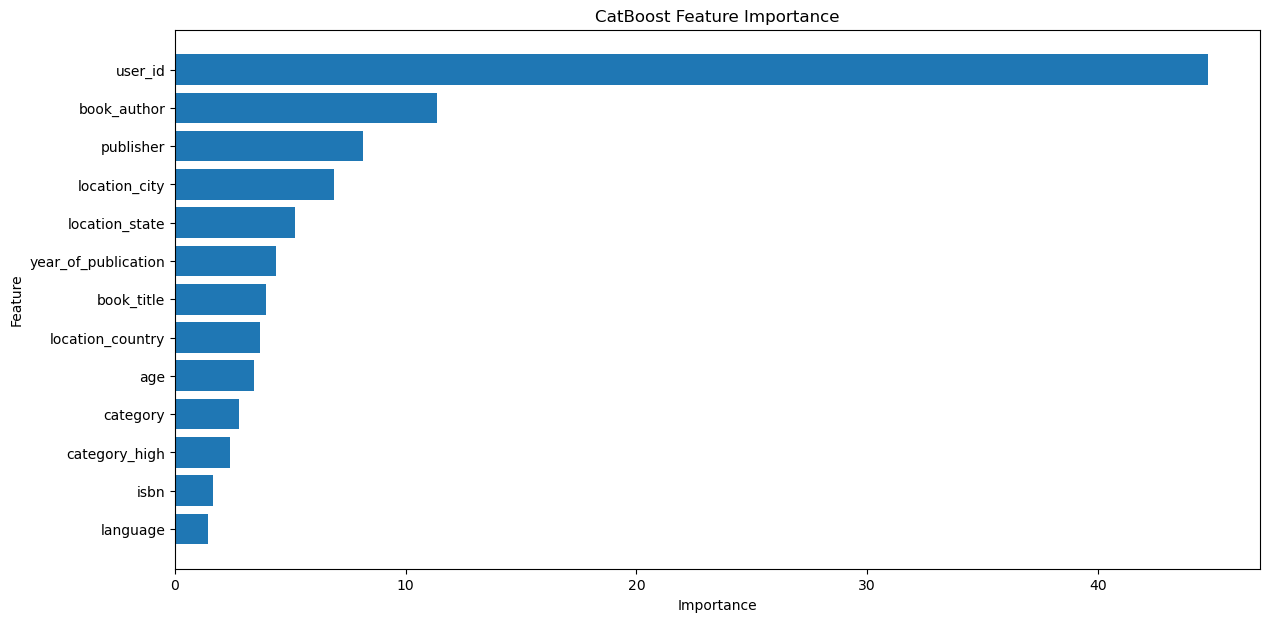

In [19]:
catboost.feature_importance()